### スクレイピング


https://www.baitoru.com/kanto/jlist/tokyo/23ku/otaku/　にアクセスしてURLに対してリクエストを送りレスポンスを返します。htmlを解析し求人情報を格納し、求人情報を処理するためにループしjob_Dataに保存する。各求人記事からタイトル、リンク、会社名を抽出し辞書に格納します。divタグを探し存在したら辞書に格納。その後職種情報、給与情報、勤務時間をを取得し

In [5]:
import requests
from bs4 import BeautifulSoup
# URLにアクセス
url = "https://www.baitoru.com/kanto/jlist/tokyo/23ku/otaku/"
response = requests.get(url)
# レスポンスのHTMLを解析
soup = BeautifulSoup(response.content, 'html.parser')
# データを格納するリスト
job_list = []
# 各 <article class="list-jobListDetail"> を探索
articles = soup.find_all('article', class_='list-jobListDetail')
# 各求人情報を取得
for article in articles:
    job_data = {}
    # 求人タイトルとリンク
    job_title_tag = article.find('h3')
    if job_title_tag:
        job_link_tag = job_title_tag.find('a')
        if job_link_tag:
            job_data['job_title'] = job_link_tag.get_text(strip=True)
            job_data['job_link'] = "https://www.baitoru.com" + job_link_tag['href']
    # 会社名
    company_name_tag = article.find('p')
    if company_name_tag:
        job_data['company_name'] = company_name_tag.get_text(strip=True)
    # <div class="pt03"> 内の情報を取得
    pt03_div = article.find('div', class_='pt03')
    if pt03_div:
        job_info = {}
        # 職種情報
        job_type_dl = pt03_div.find('dl')
        if job_type_dl:
            job_type_dt = job_type_dl.find('dt')
            job_type_dd = job_type_dl.find('dd')
            if job_type_dt and job_type_dd:
                job_info['job_type'] = job_type_dt.get_text(strip=True)
                job_info['job_type_details'] = job_type_dd.get_text(strip=True)
        # 給与情報
        salary_dl = pt03_div.find_all('dl')[1]  # 給与は2番目のdl
        if salary_dl:
            salary_dt = salary_dl.find('dt')
            salary_dd = salary_dl.find('dd')
            if salary_dt and salary_dd:
                job_info['salary'] = salary_dt.get_text(strip=True)
                job_info['salary_details'] = salary_dd.get_text(strip=True)
        # 勤務時間情報
        work_time_dl = pt03_div.find_all('dl')[2]  # 勤務時間は3番目のdl
        if work_time_dl:
            work_time_dt = work_time_dl.find('dt')
            work_time_dd = work_time_dl.find('dd')
            if work_time_dt and work_time_dd:
                job_info['work_time'] = work_time_dt.get_text(strip=True)
                job_info['work_time_details'] = work_time_dd.get_text(strip=True)
        # job_info が存在すれば、job_data に追加
        if job_info:
            job_data['job_info'] = job_info
    # 求人情報が存在すれば、job_list に追加
    if job_data:
        job_list.append(job_data)
# 結果を出力
for job in job_list:
    print("Job Title:", job.get('job_title'))
    print("Job Link:", job.get('job_link'))
    print("Company Name:", job.get('company_name'))
    if 'job_info' in job:
        job_info = job['job_info']
        print("Job Type:", job_info.get('job_type'))
        print("Job Type Details:", job_info.get('job_type_details'))
        print("Salary:", job_info.get('salary'))
        print("Salary Details:", job_info.get('salary_details'))
        print("Work Time:", job_info.get('work_time'))
        print("Work Time Details:", job_info.get('work_time_details'))
    print('-' * 40)


Job Title: 【全員面接】来社不要で採用！日払い/短期・週1~もOK！
Job Link: https://www.baitoru.com/kanto/jlist/tokyo/23ku/otaku/job138237146/
Company Name: Happyボーナス38,000円
Job Type: 職種
Job Type Details: [ア・パ]①②警備員、交通誘導警備、案内(インフォメーション/レセプション)・フロント
Salary: 給与
Salary Details: [ア・パ]①日給11,000円～12,500円、②日給12,800円～14,300円
Work Time: 勤務時間
Work Time Details: [ア・パ]①08:00～17:00、②20:00～05:00
----------------------------------------
Job Title: 日払い・週払いOK！貯金が苦手なあなたにぴったりな警備バイト
Job Link: https://www.baitoru.com/kanto/jlist/tokyo/23ku/otaku/job137620615/
Company Name: Happyボーナス83,000円
Job Type: 職種
Job Type Details: [ア・パ]①②③交通誘導警備、警備員、ドライバー・運転手
Salary: 給与
Salary Details: [ア・パ]①日給14,375円～15,875円、②日給12,875円～16,275円、③日給11,000円～14,400円
Work Time: 勤務時間
Work Time Details: [ア・パ]①②20:00～05:00、③08:00～17:00
----------------------------------------
Job Title: 働いたその日に給与がもらえる！スグ働ける&スグ稼げる！@警備
Job Link: https://www.baitoru.com/kanto/jlist/tokyo/23ku/otaku/job137620622/
Company Name: Happyボーナス83,000円
Job Type: 職種
Job Type Details: [ア・パ]①②③交通誘導

SQliteデータベースを作成しテーブルを作成する。求人情報を取得するためのループをし各ページが正常な状態であるか確認します。
指定のタグを全て探し各求人情報は辞書としてdata.dbに保存する。
その後も各情報を取得し辞書に保存し変更をデータベースにコミットしデータベース接続を閉じる。

In [6]:
import sqlite3
import requests
from bs4 import BeautifulSoup
# SQLiteデータベース接続（なければ作成）
conn = sqlite3.connect('jobs.db')
cursor = conn.cursor()
# jobs テーブルを作成
cursor.execute('''
    CREATE TABLE IF NOT EXISTS jobs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        job_title TEXT,
        job_link TEXT,
        company_name TEXT,
        job_type TEXT,
        job_type_details TEXT,
        salary TEXT,
        salary_details TEXT,
        work_time TEXT,
        work_time_details TEXT
    )
''')
# ベースURL（最初のページ）
base_url = "https://www.baitoru.com/kanto/jlist/tokyo/23ku/otaku/?page="
# 1ページ目から10ページ目まで繰り返す
for page_num in range(1, 11):
    print(f"Scraping page {page_num}...")
    # ページ番号をURLに追加
    url = base_url + str(page_num)
    response = requests.get(url)
    # レスポンスが正常か確認
    if response.status_code != 200:
        print(f"Failed to retrieve page {page_num}")
        continue
    # レスポンスのHTMLを解析
    soup = BeautifulSoup(response.content, 'html.parser')
    # 各 <article class="list-jobListDetail"> を探索
    articles = soup.find_all('article', class_='list-jobListDetail')
    # 各求人情報を取得
    for article in articles:
        job_data = {}
        # 求人タイトルとリンク
        job_title_tag = article.find('h3')
        if job_title_tag:
            job_link_tag = job_title_tag.find('a')
            if job_link_tag:
                job_data['job_title'] = job_link_tag.get_text(strip=True)
                job_data['job_link'] = "https://www.baitoru.com" + job_link_tag['href']
        # 会社名
        company_name_tag = article.find('p')
        if company_name_tag:
            job_data['company_name'] = company_name_tag.get_text(strip=True)
        # <div class="pt03"> 内の情報を取得
        pt03_div = article.find('div', class_='pt03')
        if pt03_div:
            job_info = {}
            # 職種情報
            job_type_dl = pt03_div.find('dl')
            if job_type_dl:
                job_type_dt = job_type_dl.find('dt')
                job_type_dd = job_type_dl.find('dd')
                if job_type_dt and job_type_dd:
                    job_info['job_type'] = job_type_dt.get_text(strip=True)
                    job_info['job_type_details'] = job_type_dd.get_text(strip=True)
            # 給与情報
            salary_dl = pt03_div.find_all('dl')[1]  # 給与は2番目のdl
            if salary_dl:
                salary_dt = salary_dl.find('dt')
                salary_dd = salary_dl.find('dd')
                if salary_dt and salary_dd:
                    job_info['salary'] = salary_dt.get_text(strip=True)
                    job_info['salary_details'] = salary_dd.get_text(strip=True)
            # 勤務時間情報
            work_time_dl = pt03_div.find_all('dl')[2]  # 勤務時間は3番目のdl
            if work_time_dl:
                work_time_dt = work_time_dl.find('dt')
                work_time_dd = work_time_dl.find('dd')
                if work_time_dt and work_time_dd:
                    job_info['work_time'] = work_time_dt.get_text(strip=True)
                    job_info['work_time_details'] = work_time_dd.get_text(strip=True)
            # job_info が存在すれば、job_data に追加
            if job_info:
                job_data['job_type'] = job_info.get('job_type')
                job_data['job_type_details'] = job_info.get('job_type_details')
                job_data['salary'] = job_info.get('salary')
                job_data['salary_details'] = job_info.get('salary_details')
                job_data['work_time'] = job_info.get('work_time')
                job_data['work_time_details'] = job_info.get('work_time_details')
        # データベースに挿入
        if job_data:
            cursor.execute('''
                INSERT INTO jobs (job_title, job_link, company_name, job_type, job_type_details, salary, salary_details, work_time, work_time_details)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                job_data['job_title'],
                job_data['job_link'],
                job_data['company_name'],
                job_data['job_type'],
                job_data['job_type_details'],
                job_data['salary'],
                job_data['salary_details'],
                job_data['work_time'],
                job_data['work_time_details']
            ))
# 変更をコミットしてデータベースを閉じる
conn.commit()
conn.close()
print("Job data has been inserted into the database.")








Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Job data has been inserted into the database.


In [129]:
import sqlite3
# SQLiteデータベースファイルのパス
db_file = 'jobs.db'
# データベース接続
conn = sqlite3.connect(db_file)
cursor = conn.cursor()
# job_type_details別の総数を取得（LIKE演算子を使って類似文字列も扱う）
cursor.execute('''
SELECT job_type_details, COUNT(*) AS job_count
FROM jobs
GROUP BY job_type_details
ORDER BY job_count DESC
''')
# 結果の取得と表示
job_type_details = cursor.fetchall()
print("Job Type Summary:")
for job_type_details_value, job_count in job_type_details:
    print(f"Job Type: {job_type_details_value}, Count: {job_count}")
# 複数の部分文字列を検索して類似の文字列を表示
keywords = ['警備', '運転手', '営業', '事務']  # 類似文字列のキーワード
# 各キーワードについて検索
for keyword in keywords:
    print(f"\nSearching for job types containing '{keyword}':")
    cursor.execute(f'''
    SELECT job_type_details, COUNT(*) AS job_count
    FROM jobs
    WHERE job_type_details LIKE ?
    GROUP BY job_type_details
    ORDER BY job_count DESC
    ''', ('%' + keyword + '%',))
    similar_job_type_details = cursor.fetchall()
    # 結果の表示
    if similar_job_type_details:
        for job_type_details_value, job_count in similar_job_type_details:
            print(f"Job Type: {job_type_details_value}, Count: {job_count}")
    else:
        print(f"No job types found containing '{keyword}'.")
# DB接続を閉じる
conn.close()













Job Type Summary:
Job Type: [ア・パ]①②③交通誘導警備、警備員、ドライバー・運転手, Count: 50
Job Type: [派遣]デリ・惣菜販売・スイーツ販売、レジ打ち、ホールスタッフ(配膳), Count: 10
Job Type: [派遣]キッチンスタッフ、ホールスタッフ(配膳)、フード・飲食その他, Count: 10
Job Type: [派遣]①施設警備(館内警備)、ビルメンテナンス・管理、オフィスその他、②施設警備(館内警備)、ビルメンテナンス・管理, Count: 10
Job Type: [正]梱包、仕分け・シール貼り、倉庫管理・入出荷, Count: 10
Job Type: [正]仕分け・シール貼り、品出し(ピッキング)、軽作業・物流その他, Count: 10
Job Type: [正]①②ドライバー・運転手、配達・配送・宅配便、軽作業・物流その他, Count: 10
Job Type: [ア・パ]梱包、移転・引越し、配達・配送・宅配便, Count: 10
Job Type: [ア・パ]仕分け・シール貼り、配達・配送・宅配便、軽作業・物流その他, Count: 10
Job Type: [ア・パ]パチンコ・スロット(ホール)、パチンコ・スロット(カウンター), Count: 10
Job Type: [ア・パ]バーテンダー、フロアレディ・カウンターレディ(ナイトワーク系)、ガールズバー・キャバクラ・スナックその他(ナイトワーク系), Count: 10
Job Type: [ア・パ]①②警備員、交通誘導警備、案内(インフォメーション/レセプション)・フロント, Count: 10
Job Type: [ア・パ]①②案内(インフォメーション/レセプション)・フロント、受付、データ入力、タイピング(PC・パソコン・インターネット), Count: 10
Job Type: [ア・パ]①②ホールスタッフ(配膳)、キッチンスタッフ、バリスタ, Count: 10
Job Type: [ア・パ]①②パチンコ・スロット(ホール)、パチンコ・スロット(カウンター)、サービスその他, Count: 10
Job Type: [ア・パ]①②③品出し(ピッキング)、仕分け・シール貼り、検品, Count: 10

Search

立てた仮説として同じ会社の求人数とバイトル特有のHappy Bonusの額が比例しているのではないかという仮説を立てた。
結果としては仮設はあっていたが、主にパートに対して向けたものでありアルバイトの人では比例していなかった。
他にもエンジニアや技術職は他の職種よりも給与が高い傾向にあった。

/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabto

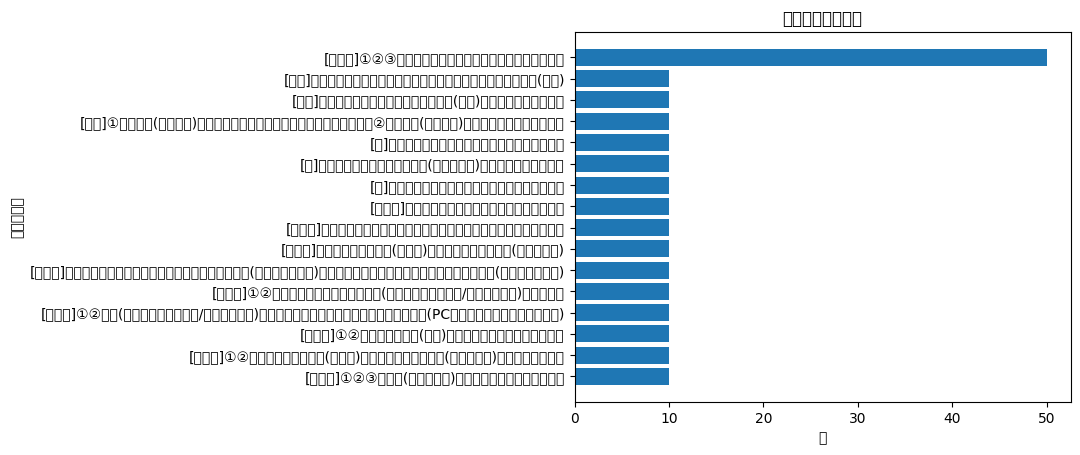


'警備'を含む仕事の種類の検索結果:


/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21547 (\N{CJK UNIFIED IDEOGRAPH-542B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santayarimizu/Lecture/PR2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12416 (\N{HIRAGANA LETTER MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


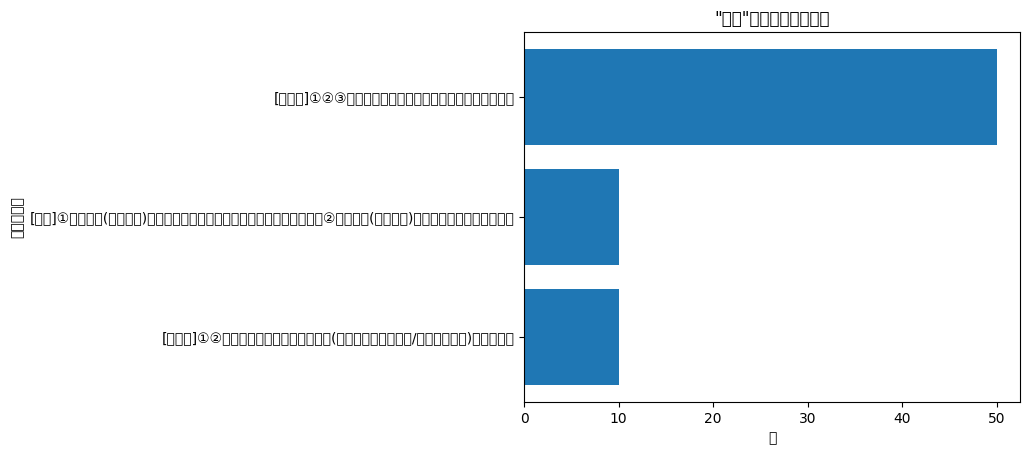


'運転手'を含む仕事の種類の検索結果:


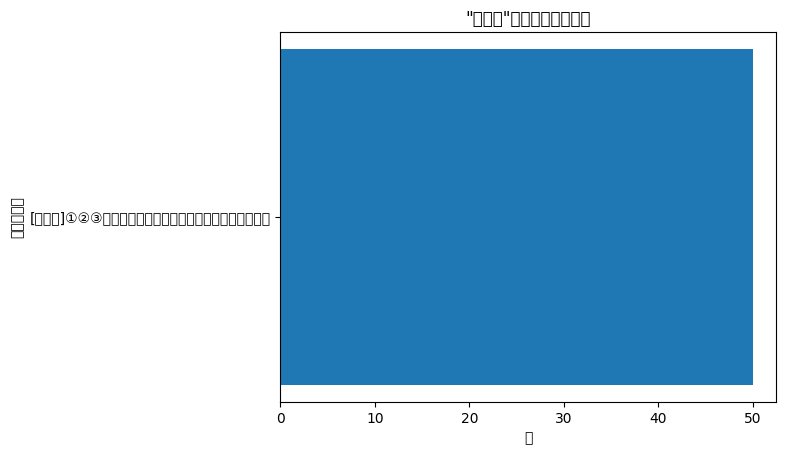


'営業'を含む仕事の種類の検索結果:
'営業'を含む仕事の種類は見つかりませんでした。

'事務'を含む仕事の種類の検索結果:
'事務'を含む仕事の種類は見つかりませんでした。


In [18]:
import sqlite3
import matplotlib.pyplot as plt


# SQLiteデータベースファイルのパス
db_file = 'jobs.db'
# データベース接続
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# job_type_details別の総数を取得（LIKE演算子を使って類似文字列も扱う）
cursor.execute('''
SELECT job_type_details, COUNT(*) AS job_count
FROM jobs
GROUP BY job_type_details
ORDER BY job_count DESC
''')
# 結果の取得と表示
job_type_details = cursor.fetchall()

# データを棒グラフ用に整形
job_types = [row[0] for row in job_type_details]
job_counts = [row[1] for row in job_type_details]

# 棒グラフをプロット
fig, ax = plt.subplots()
ax.barh(job_types, job_counts)
ax.set_xlabel('数')
ax.set_ylabel('仕事の種類')
ax.set_title('仕事の種類の概要')
ax.invert_yaxis()  # 上位の結果が上に表示されるように反転

plt.show()

# 複数の部分文字列を検索して類似の文字列を表示
keywords = ['警備', '運転手', '営業', '事務']  # 類似文字列のキーワード

for keyword in keywords:
    print(f"\n'{keyword}'を含む仕事の種類の検索結果:")
    cursor.execute(f'''
    SELECT job_type_details, COUNT(*) AS job_count
    FROM jobs
    WHERE job_type_details LIKE ?
    GROUP BY job_type_details
    ORDER BY job_count DESC
    ''', ('%' + keyword + '%',))
    similar_job_type_details = cursor.fetchall()
    
    # 結果の表示
    if similar_job_type_details:
        job_types = [row[0] for row in similar_job_type_details]
        job_counts = [row[1] for row in similar_job_type_details]

        fig, ax = plt.subplots()
        ax.barh(job_types, job_counts)
        ax.set_xlabel('数')
        ax.set_ylabel('仕事の種類')
        ax.set_title(f'"{keyword}"を含む仕事の種類')
        ax.invert_yaxis()  # 上位の結果が上に表示されるように反転

        plt.show()
    else:
        print(f"'{keyword}'を含む仕事の種類は見つかりませんでした。")

# DB接続を閉じる
conn.close()